In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [2]:
import cfdnetplus

In [3]:
path_to_main= 'data/kolmogorv/'
folders=['ER1000_Tin300_Uin040_TwallAdiabatic',
         'ER600_Tin300_Uin040_TwallAdiabatic',
         'ER650_Tin300_Uin040_TwallAdiabatic',
         'ER700_Tin300_Uin040_TwallAdiabatic',
         'ER750_Tin300_Uin040_TwallAdiabatic',
         'ER800_Tin300_Uin040_TwallAdiabatic',
         'ER850_Tin300_Uin040_TwallAdiabatic',
         'ER900_Tin300_Uin040_TwallAdiabatic',
         'ER950_Tin300_Uin040_TwallAdiabatic']
fields= ['AR', 'CH4', 'CO', 'CO2', 'H2O', 'N2', 'O2', 'Qdot', 'T', 'p', 'pd', 'U']
mode= 'xz'
xlim =[0,0.0135]
zlim = [0 , 0.0025]
xres=256
zres=66
ycut=0.0006
modelid='model1'

In [4]:
cfdnetplus.VTK2np(path_to_main, folders, fields, mode,xres,zres,xlim,zlim,ycut)

processing data in data/kolmogorv/ER1000_Tin300_Uin040_TwallAdiabatic/VTK/
(51, 66, 256, 14)
data written todata/kolmogorv/ER1000_Tin300_Uin040_TwallAdiabatic/VTK/df
processing data in data/kolmogorv/ER600_Tin300_Uin040_TwallAdiabatic/VTK/
(71, 66, 256, 14)
data written todata/kolmogorv/ER600_Tin300_Uin040_TwallAdiabatic/VTK/df
processing data in data/kolmogorv/ER650_Tin300_Uin040_TwallAdiabatic/VTK/
(51, 66, 256, 14)


ValueError: cannot reshape array of size 615250944 into shape (51,66,256,14)

In [9]:

df = np.empty((0,66,256,7))
df_label = np.empty((0,66,256,7))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
print(df_label.shape)

(2295, 66, 256, 7)


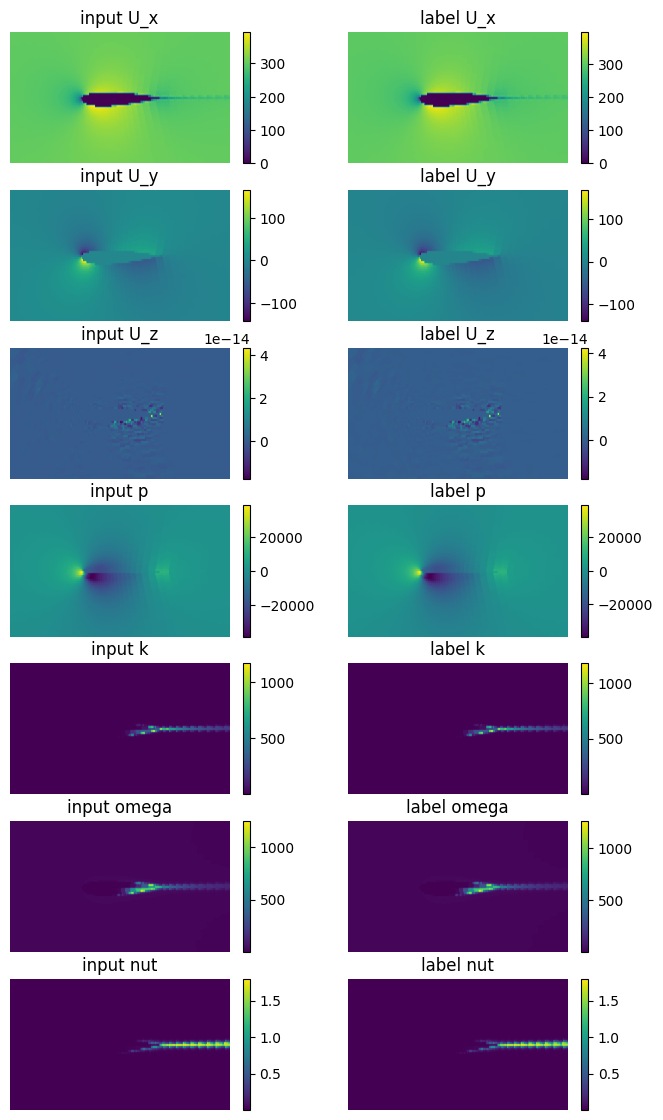

In [10]:

n=1000
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape
titles= ['U_x','U_y','U_z','p','k','omega', 'nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

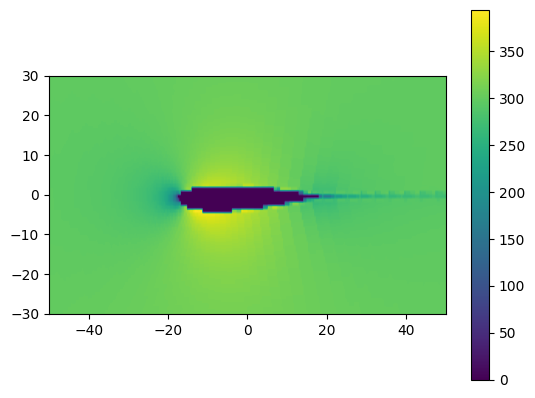

In [11]:
plt.imshow(df[1000,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.colorbar()

In [12]:
df_label[n,:,:,3].shape

(66, 256)

In [18]:
#normalise U Vektors
U_max=np.max(abs(df[:,:,:,[0,1,2]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))

model_path='cfdnetplus_models/'+modelid+'/'
normal=np.array([U_max,U_max,U_max, p_max,k_max, omega_max,nut_max]).reshape(1,1,1,7)
print(normal)

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)


[[[[4.41323047e+03 4.41323047e+03 4.41323047e+03 7.33556320e+07
    2.83279031e+05 1.93653164e+04 4.86423264e+01]]]]


In [19]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

U
p
k
omega
nut



In [20]:
df1=df*1/normal
df_label1=df_label/normal

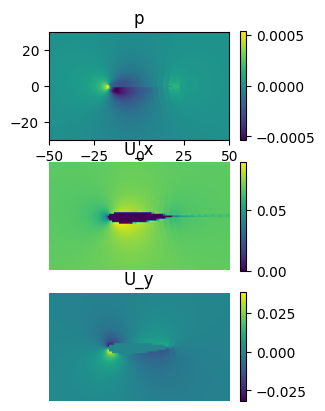

In [21]:
fig = plt.figure()

fig.add_subplot(3, 2, 1)
plt.imshow(df_label1[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('p')
plt.axis('on')
plt.colorbar()


fig.add_subplot(3, 2, 3)
plt.imshow(df_label1[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_x')
plt.axis('off')
plt.colorbar()

fig.add_subplot(3, 2, 5)
plt.imshow(df_label1[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_y')
plt.axis('off')

plt.colorbar()
plt.show()

In [22]:
train_data, test_data, label_train, label_test = train_test_split (df1, df_label1, test_size = 0.15)

In [102]:
ylim[1]

60

20


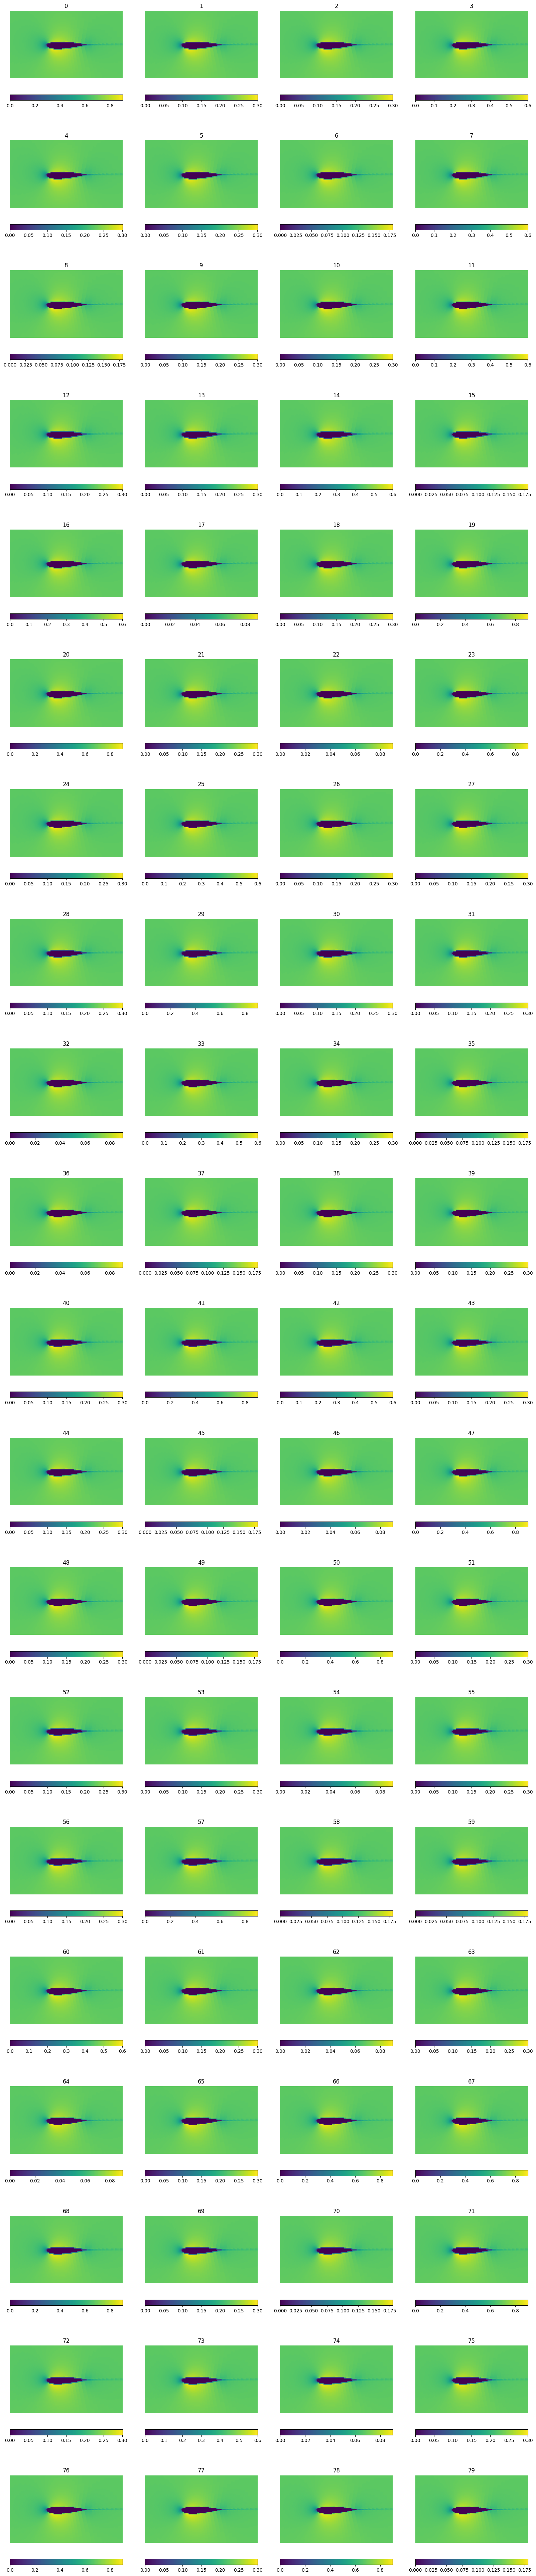

In [23]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

In [24]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='tanh',padding="same", input_shape=(66,256, 7)))
model.add(layers.Conv2D(64,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(7,(4,16),(2,8), activation='linear', padding="same"))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 32, 16)        5392      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 8, 64)         36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         3145984   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 11, 8, 32)        1146912   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 33, 32, 16)       24592     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 66, 256, 7)       7

In [45]:
model.compile(optimizer='adam',
              loss='mean_squared_logarithmic_error')

In [46]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0']
1
training_1


In [47]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [48]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 6.6054e-05
Epoch 1: loss improved from inf to 0.00007, saving model to training/training_1\vae_best_model_relu.epoch01-loss0.00007.w
61/61 [==============================] - 18s 292ms/step - loss: 6.6054e-05 - val_loss: 7.3764e-05
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 1.4871e-05
Epoch 2: loss improved from 0.00007 to 0.00001, saving model to training/training_1\vae_best_model_relu.epoch02-loss0.00001.w
61/61 [==============================] - 17s 285ms/step - loss: 1.4871e-05 - val_loss: 9.2020e-06
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 5.8832e-06
Epoch 3: loss improved from 0.00001 to 0.00001, saving model to training/training_1\vae_best_model_relu.epoch03-loss0.00001.w
61/61 [==============================] - 18s 291ms/step - loss: 5.8832e-06 - val_loss: 1.3246e-05
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 4.4056e-06
Epoch 4: los

KeyboardInterrupt: 

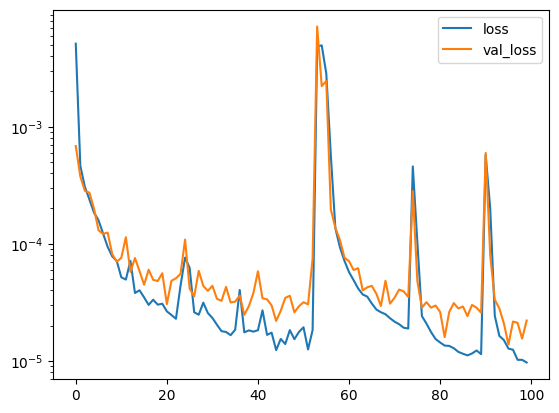

In [34]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [59]:
#filefolder= 'training_6'

#folders=os.listdir('training/'+filefolder)
folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

100
vae_best_model_relu.epoch100-loss0.00001.w


In [60]:
#weights_path='training/'+filefolder+'/'+latest[0]

weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_0/vae_best_model_relu.epoch100-loss0.00001.w


In [61]:
test=model.predict(test_data)

11/11 [==============================] - 1s 53ms/step


In [73]:
print(label_test.shape[0])
n=5
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345
max: 0.62837213
min: -0.019497566


(345, 66, 256, 7)


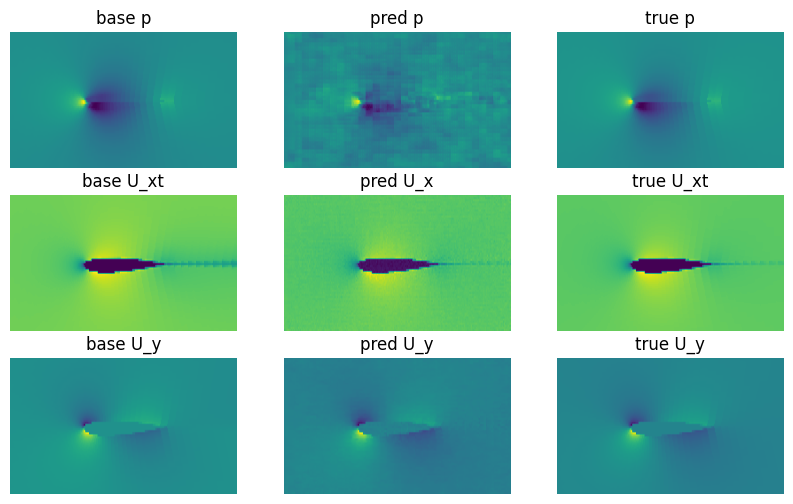

In [63]:
print(test_data.shape)
n=23
fig = plt.figure(figsize=(10, 6))

fig.add_subplot(3, 3, 2)
plt.imshow(test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred p')
plt.axis('off')


fig.add_subplot(3, 3,5)
plt.imshow(test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred U_x')
plt.axis('off')

fig.add_subplot(3, 3, 8)
plt.imshow(test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred U_y')
plt.axis('off')

fig.add_subplot(3, 3, 1)
plt.imshow(test_data[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base p')
plt.axis('off')


fig.add_subplot(3, 3,4)
plt.imshow(test_data[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 7)
plt.imshow(test_data[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_y')
plt.axis('off')


plt.show()

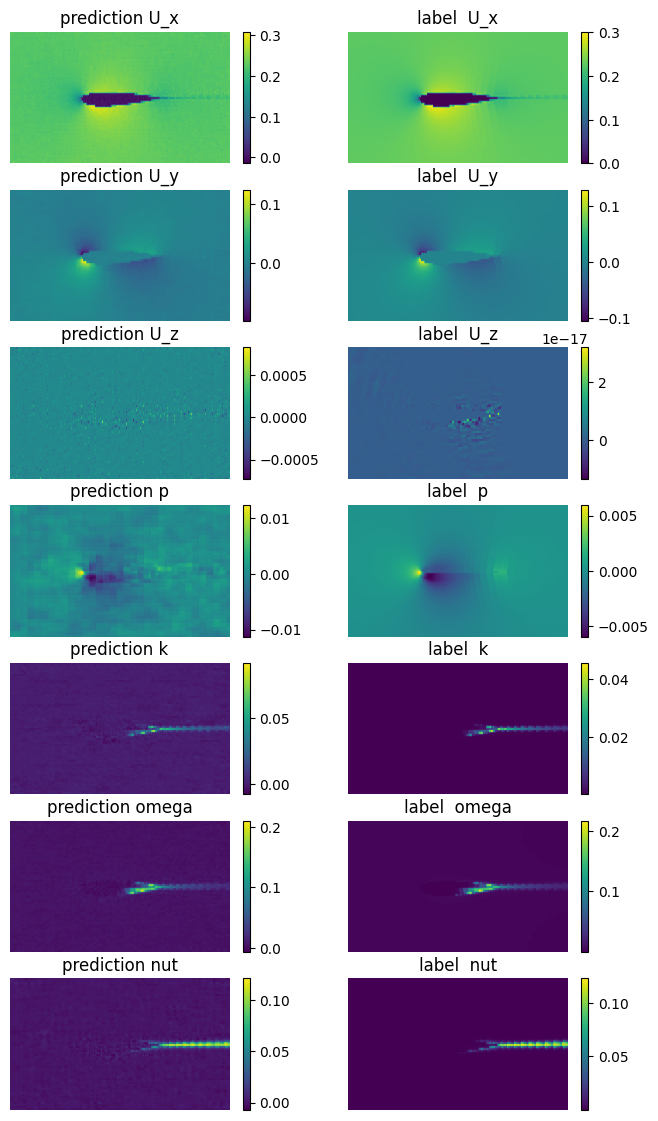

In [76]:
n=23
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=test.shape
titles= ['U_x','U_y','U_z','p','k','omega', 'nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

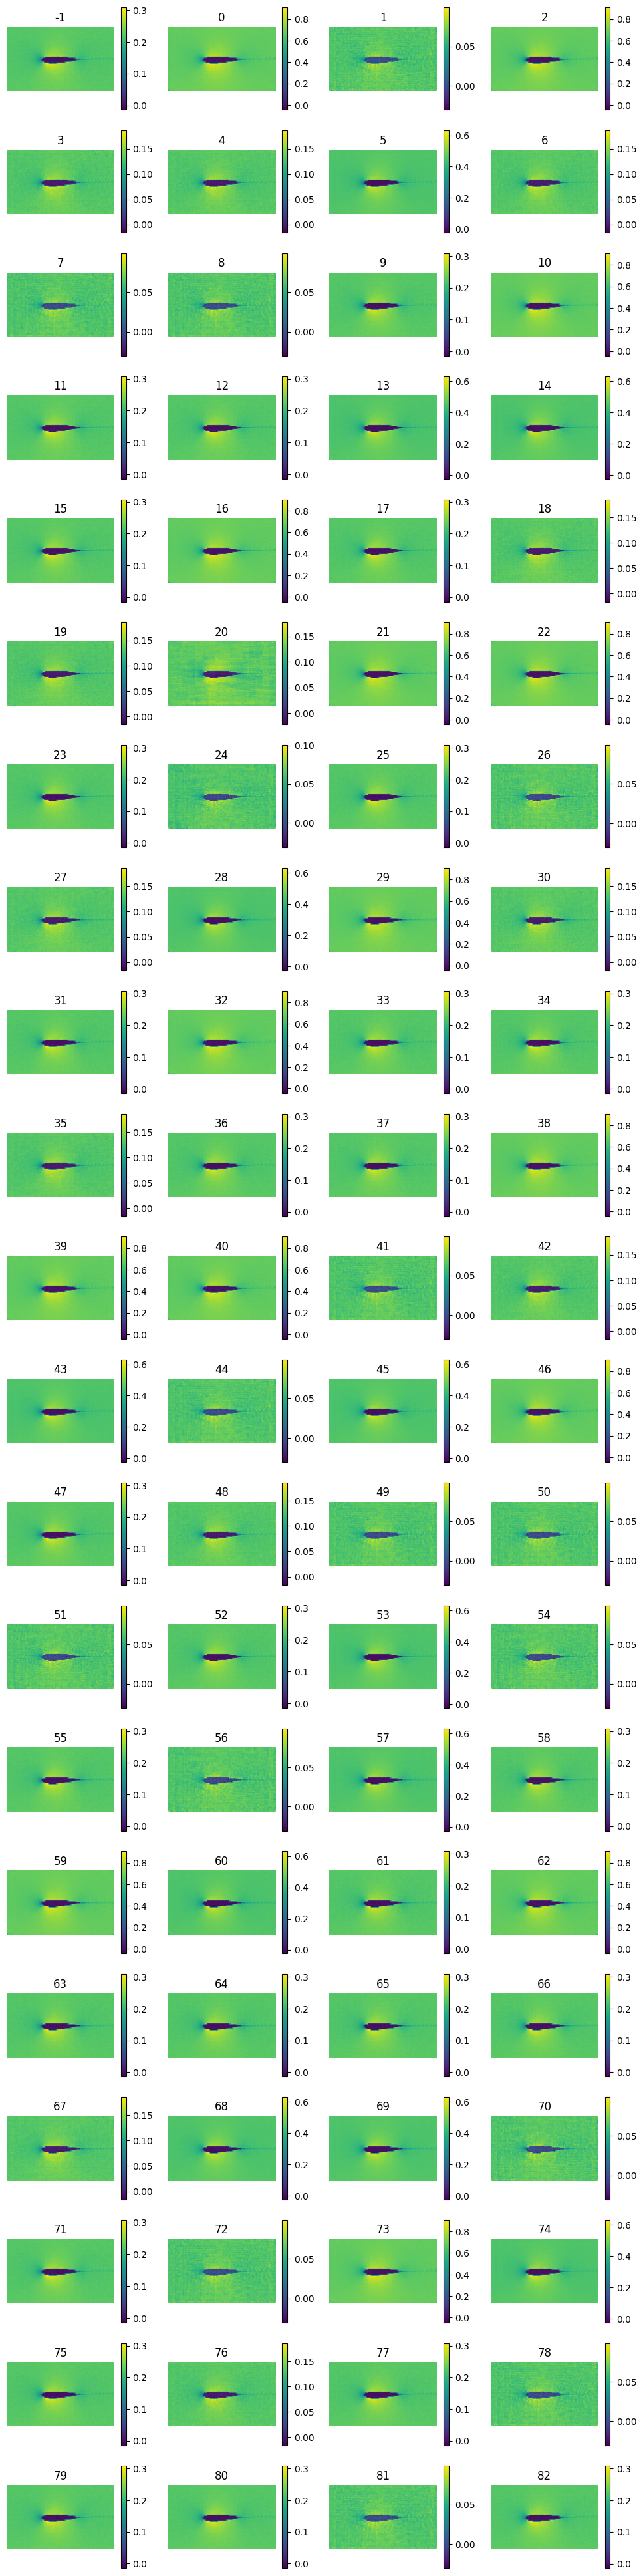

In [77]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()
    

In [57]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,3],label_test[i,:,:,3]))
    ssim1.append(ssim(test[i,:,:,3],label_test[i,:,:,3]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:0.004268981377960514
0.1615901839459936
0.002357455493213041
average ssim: 0.1640604946376105
average mse: 0.002592235416306115


In [43]:
#os.mkdir('cfdnetplus_models')
model.save('cfdnetplus_models/model1')

INFO:tensorflow:Assets written to: cfdnetplus_models/model1\assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model1\assets
